<a href="https://colab.research.google.com/github/abhiram212/Resume/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                  Time      Open      High       Low     Close  Volume
0  2025-03-20 00:00:00  1.197087  1.205902  1.081064  1.113919  582879
1  2025-03-20 01:00:00  1.189843  1.214834  1.044642  1.111439  126551
2  2025-03-20 02:00:00  1.172803  1.219899  1.036512  1.102160  541424
3  2025-03-20 03:00:00  1.194285  1.296451  1.005938  1.196706  713766
4  2025-03-20 04:00:00  1.153508  1.299275  1.042662  1.128358  185046


<ipython-input-2-3da9ec60ecac>:37: DeprecationWarning:

write_transaction has been renamed to execute_write

<ipython-input-2-3da9ec60ecac>:51: DeprecationWarning:

write_transaction has been renamed to execute_write



Outliers detected:
Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume, close_zscore, volume_zscore]
Index: []
Trades deviating from the expected guidelines:
Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume, close_zscore, volume_zscore]
Index: []


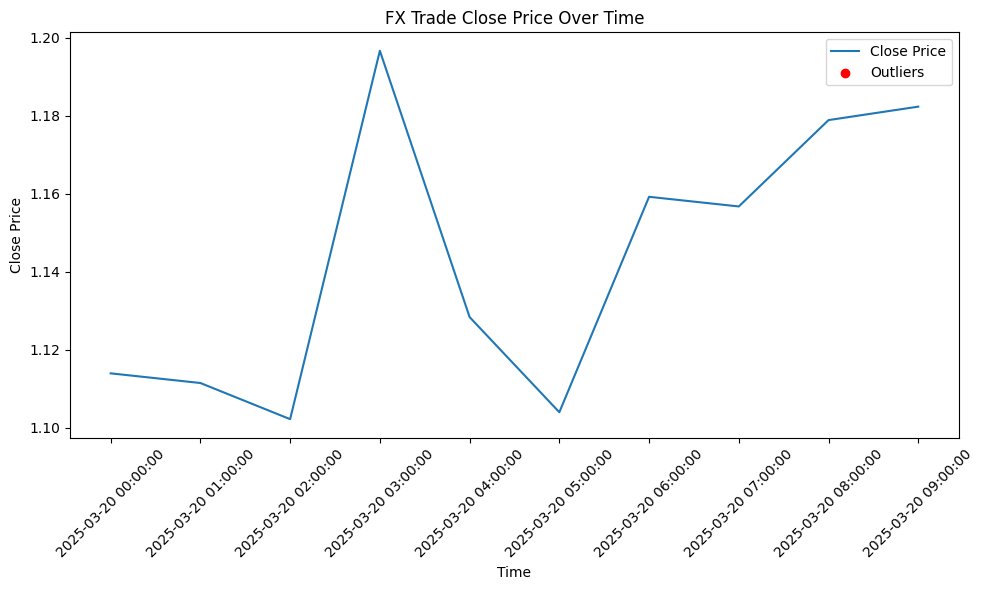

Total trades: 10


In [ ]:
# Step 1: Install required libraries for the librarires
!pip install neo4j pandas numpy matplotlib plotly py2neo

# Step 2: Import the libraries which are required to the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from neo4j import GraphDatabase
from py2neo import Graph

# Step 3: Set Neo4j connection
uri = "neo4j+s://40eee460.databases.neo4j.io"
username = "neo4j"
password = "hvMg8ZEdGfpcoVII-o5uL4JrHyyvSskncn7FChEYjmw"

driver = GraphDatabase.driver(uri, auth=(username, password))
graph = Graph(uri, auth=(username, password))

# Step 4: Load FX trade data from the CSV file
data = pd.read_csv('fx_trades.csv')
print(data.head())

# Step 5: Create a function to insert trades into Neo4j
def create_trade(tx, time, open_price, high_price, low_price, close_price, volume):
    query = (
        "CREATE (t:Trade {time: $time, open: $open_price, high: $high_price, "
        "low: $low_price, close: $close_price, volume: $volume})"
    )
    tx.run(query, time=time, open_price=open_price, high_price=high_price,
           low_price=low_price, close_price=close_price, volume=volume)

# Step 6: Insert the FX trade data into Neo4j
with driver.session() as session:
    for _, row in data.iterrows():
        session.write_transaction(create_trade, row['Time'], row['Open'], row['High'],
                                  row['Low'], row['Close'], row['Volume'])

# Step 7: Create relationships between consecutive trades in Neo4j
def create_relationship(tx, time_1, time_2):
    query = (
        "MATCH (t1:Trade {time: $time_1}), (t2:Trade {time: $time_2}) "
        "CREATE (t1)-[:CONSECUTIVE]->(t2)"
    )
    tx.run(query, time_1=time_1, time_2=time_2)

with driver.session() as session:
    for i in range(1, len(data)):
        session.write_transaction(create_relationship, data.loc[i-1, 'Time'], data.loc[i, 'Time'])

# Step 8: Outlier detection using Z-score for close price and volume
data['close_zscore'] = (data['Close'] - data['Close'].mean()) / data['Close'].std()
data['volume_zscore'] = (data['Volume'] - data['Volume'].mean()) / data['Volume'].std()

outliers = data[(np.abs(data['close_zscore']) > 3) | (np.abs(data['volume_zscore']) > 3)]
print("Outliers detected:")
print(outliers)

# Step 9: Label outliers in Neo4j graph
def label_outlier(tx, time):
    query = (
        "MATCH (t:Trade {time: $time}) "
        "SET t:OUTLIER"
    )
    tx.run(query, time=time)

# Label outliers in the graph
with driver.session() as session:
    for _, row in outliers.iterrows():
        session.write_transaction(label_outlier, row['Time'])

# Step 10: Compare actual trades with expected guidelines
expected_price_range = (1.1, 1.2)
expected_volume_range = (100000, 1000000)

# Find trades that deviate from the expected range
deviations = data[
    (data['Close'] < expected_price_range[0]) |
    (data['Close'] > expected_price_range[1]) |
    (data['Volume'] < expected_volume_range[0]) |
    (data['Volume'] > expected_volume_range[1])
]
print("Trades deviating from the expected guidelines:")
print(deviations)

# Step 11: Visualization of FX trade close price over time

# Matplotlib plot for close price over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['Close'], label='Close Price')
plt.scatter(outliers['Time'], outliers['Close'], color='red', label='Outliers')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('FX Trade Close Price Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotly visualization for close price and outliers
fig = go.Figure()

# Plot the close prices
fig.add_trace(go.Scatter(x=data['Time'], y=data['Close'], mode='lines', name='Close Price'))

# Plot the outliers
fig.add_trace(go.Scatter(x=outliers['Time'], y=outliers['Close'], mode='markers', name='Outliers', marker=dict(color='red', size=8)))

fig.update_layout(title="FX Trade Close Price with Outliers",
                  xaxis_title="Time",
                  yaxis_title="Close Price",
                  template="plotly_dark")
fig.show()

# Step 12: Generate a report summarizing the findings
def generate_report(outliers, deviations):
    print(f"Total trades: {len(data)}")

generate_report(outliers, deviations)
























